In [3]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


In [ ]:
# Import des données
application_test =pd.read_csv(r'application_test.csv')
application_train =pd.read_csv(r'application_train.csv')
bureau =pd.read_csv(r'bureau.csv')
bureau_balance =pd.read_csv(r'bureau_balance.csv')
credit_card_balance =pd.read_csv(r'credit_card_balance.csv')
HomeCredit_columns_description =pd.read_csv(r'HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
installments_payments =pd.read_csv(r'installments_payments.csv')
POS_CASH_balance =pd.read_csv(r'POS_CASH_balance.csv')
previous_application =pd.read_csv(r'previous_application.csv')
sample_submission =pd.read_csv(r'sample_submission.csv')

application train est la table principale qui contient la target.
Chaque ligne y représente un crédit.  
  
application test contient les même champs que l'application test mais sans target.  
  
Bureau contient les crédits précédents des clients. Il y a autant de lignes que de crédits.  
Il peut donc y avoir plusieurs lignes par client.  
  
Bureau_balance contient le solde des crédits par mois pour chaque client.  
  
POS_CASH contient la même information que bureau_balance mais pour les crédits POS.

Credit card balance contient la même information que bureau_balance mais pour les cartes de crédit.  
  
Toutes les demandes antérieures de crédit sont contenues dans previous_application.  
  
L'historique des remboursements est contenu dans installments payments.  
  
HomeCredit Columns description décrit toutes les colonnes.

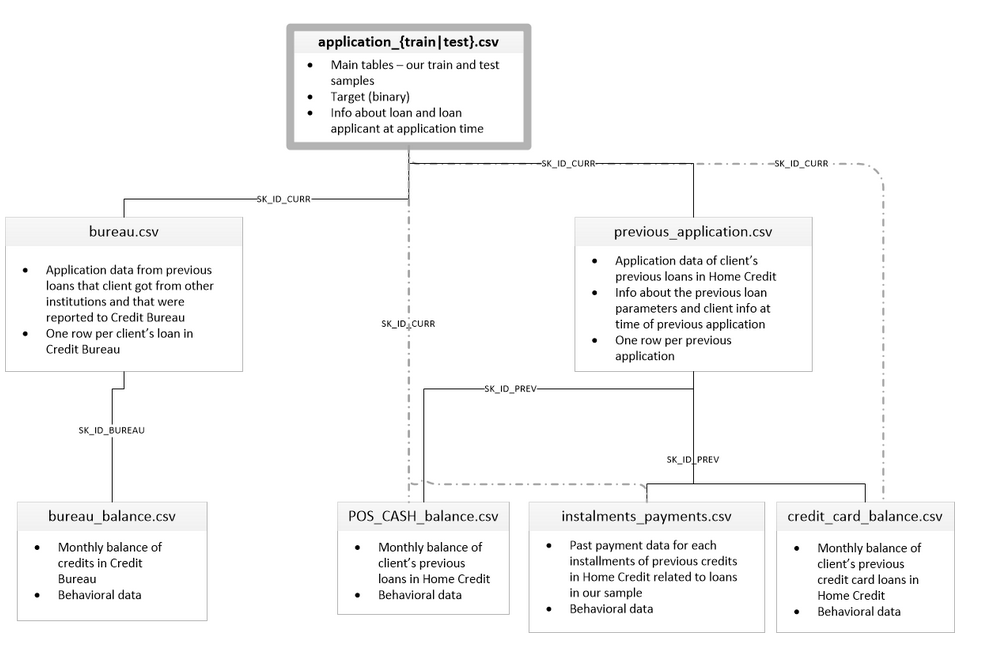

In [ ]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [ ]:
# Description des colonnes
pd.set_option("max_colwidth", 400)
HomeCredit_columns_description

In [ ]:
# On ne garde que les informations les plus récentes
POS_CASH_balance_recent = POS_CASH_balance.loc[POS_CASH_balance['MONTHS_BALANCE'] == -1]
credit_card_balance_recent = credit_card_balance.loc[credit_card_balance['MONTHS_BALANCE'] == -1]

In [ ]:
POS_CASH_balance2 = POS_CASH_balance_recent.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'POS - Retard moyen de paiement en jours': x['SK_DPD'].mean(),
    'POS - Durée moyenne des crédits précédents':  x['CNT_INSTALMENT'].mean(),
    'POS - Nombre de mensualités restantes': x['CNT_INSTALMENT_FUTURE'].sum(),
    'POS - Montant des dettes restantes': x['SK_DPD_DEF'].sum(),
}))

In [ ]:
application_train = pd.merge(application_train, POS_CASH_balance2, how="left",on="SK_ID_CURR")

In [ ]:
bureau_actif = bureau.loc[bureau['CREDIT_ACTIVE'] == 'Active']
bureau_fini = bureau.loc[bureau['CREDIT_ACTIVE'] == 'Closed']

In [ ]:
Bureau_actif = bureau_actif.groupby(by = 'SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count()
Bureau_actif.columns = ['SK_ID_CURR', 'Nombre de crédits actifs']

Bureau_fini = bureau_fini.groupby(by = 'SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count()
Bureau_fini.columns = ['SK_ID_CURR', 'Nombre de crédits remboursés']

In [ ]:
application_train = pd.merge(application_train, Bureau_actif, how = "left",on="SK_ID_CURR")
application_train = pd.merge(application_train, Bureau_fini, how = "left",on="SK_ID_CURR")

In [ ]:
bureau2 = bureau.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'bureau - Nombre de jours depuis la dernière demande': x['DAYS_CREDIT'].min(),
    'bureau - Nombre de fois ou le crédit a été prolongé':  x['CNT_CREDIT_PROLONG'].sum(),
    'bureau - Montant crédits en cours': x['AMT_CREDIT_SUM'].sum(),
    'bureau - Montant des dettes actuelles': x['AMT_CREDIT_SUM_DEBT'].sum(),
    'bureau - Montant actuel en souffrance': x['AMT_CREDIT_SUM_OVERDUE'].sum(),
}))

In [ ]:
application_train = pd.merge(application_train, bureau2, how = "left",on="SK_ID_CURR")

In [ ]:
credit_card_balance2 = credit_card_balance_recent.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'CB - Solde': x['AMT_BALANCE'].mean(),
    'CB - Limite':  x['AMT_CREDIT_LIMIT_ACTUAL'].mean(),
    'CB - Montant payé par le client': x['AMT_PAYMENT_TOTAL_CURRENT'].sum(),
    'CB - Nombre de retraits': x['CNT_DRAWINGS_ATM_CURRENT'].sum(),
}))

In [ ]:
application_train = pd.merge(application_train, credit_card_balance2, how = "left",on="SK_ID_CURR")

In [ ]:
installments_payments.shape

In [ ]:
# On ne perd que très peu de lignes à supprimer les NaN
installments_payments_NoNaN = installments_payments.dropna()
installments_payments_NoNaN.shape

In [ ]:
installments_payments2 = installments_payments_NoNaN.groupby(['SK_ID_PREV']).apply(lambda x: pd.Series({
    'IP - Retard moyen des paiements': (x['DAYS_INSTALMENT'] - x['DAYS_ENTRY_PAYMENT']).mean(),
    'IP - Paiement en souffrance moyen':  (x['AMT_INSTALMENT'] - x['AMT_PAYMENT']).mean()
}))

In [ ]:
previous_application = pd.merge(previous_application, installments_payments2, how="left",on="SK_ID_PREV")

In [ ]:
previous_application2 = previous_application.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'Previous - Montant demandé moyen': x['AMT_APPLICATION'].mean(),
    'Previous - Taux dinteret précédent moyen':  x['RATE_INTEREST_PRIMARY'].mean(),
    'IP - Retard moyen des paiements':  x['IP - Retard moyen des paiements'].mean(),
    'IP - Paiement en souffrance moyen':  x['IP - Paiement en souffrance moyen'].mean(),
}))

In [ ]:
application_train = pd.merge(application_train, previous_application2, how = "left",on="SK_ID_CURR")

In [ ]:
application_train.shape

In [ ]:
application_train.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df1.csv')

In [5]:
application_train =pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df1.csv')

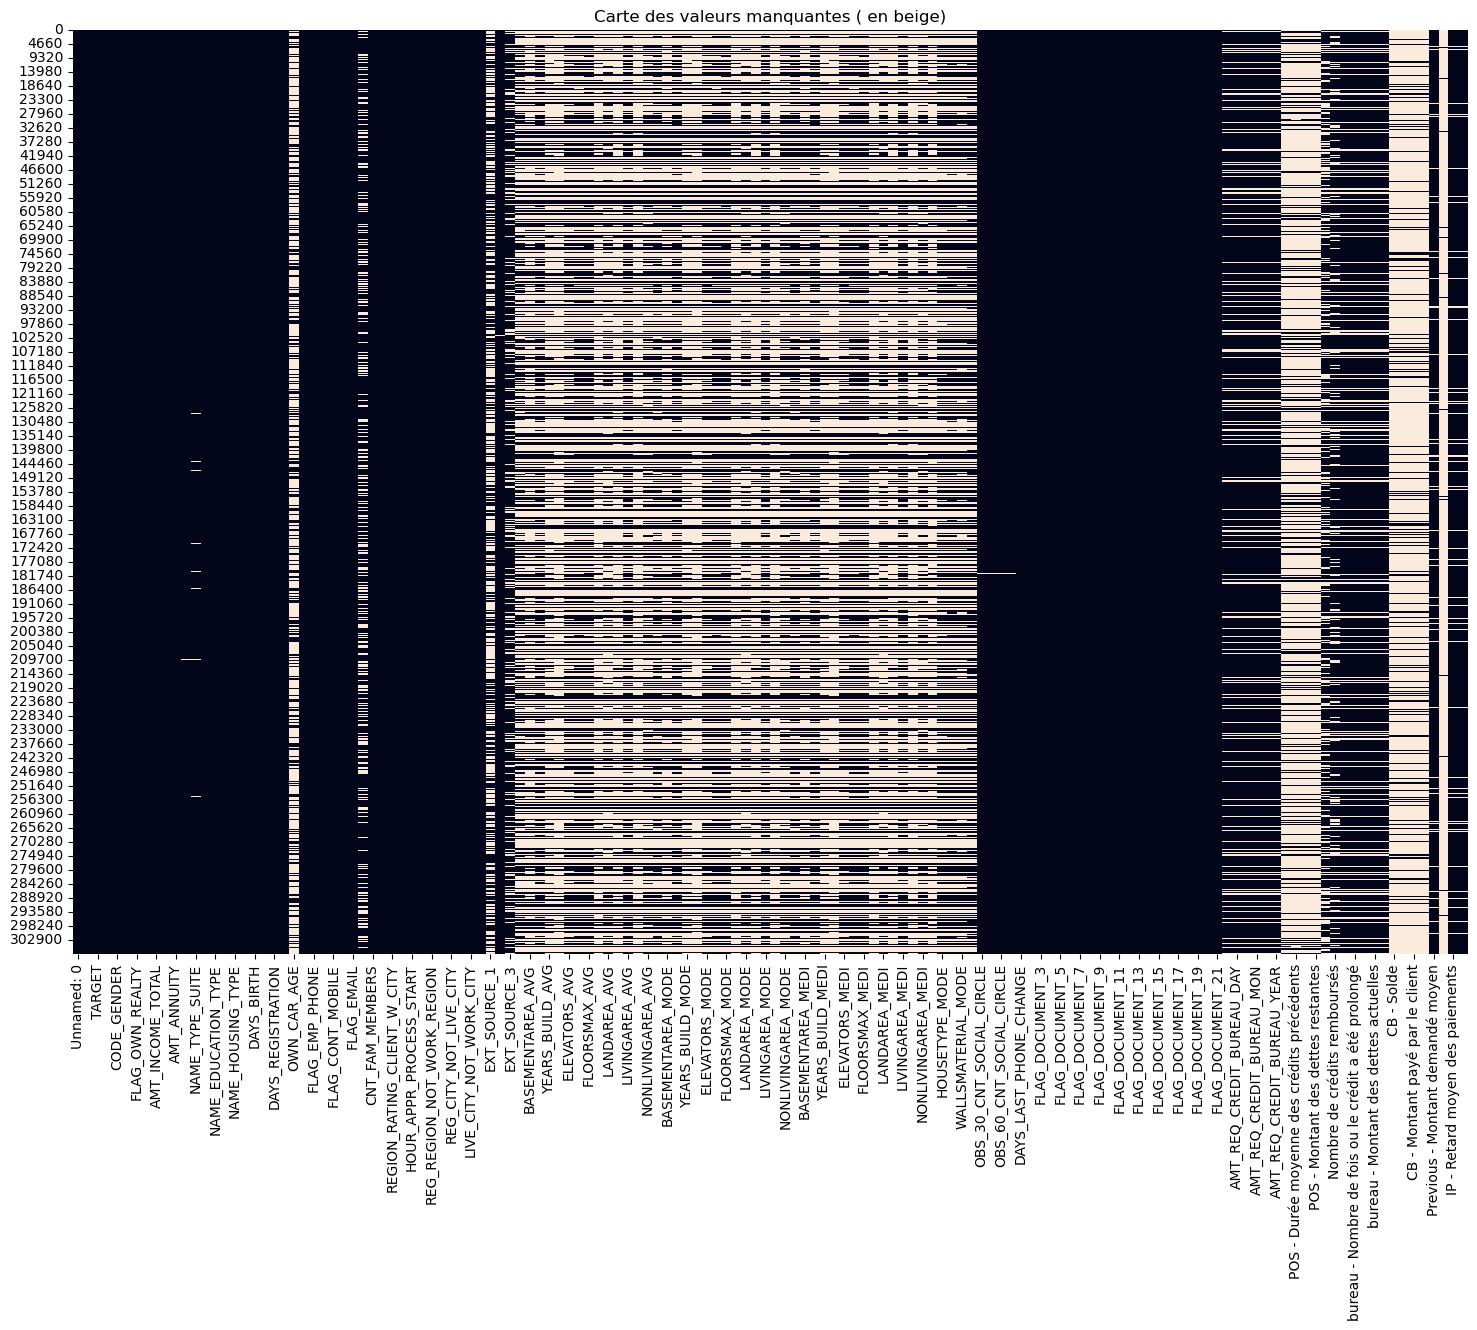

In [135]:
plt.figure(figsize=(18,12))
heat_map = sns.heatmap(application_train.isnull(),cbar = False)
plt.title("Carte des valeurs manquantes ( en beige)")
plt.show()

In [136]:
#Recherche des valeurs nulles en pourcentage par colonne
(application_train.isna().sum() / application_train.shape[0])*100

Unnamed: 0                                              0.000000
SK_ID_CURR                                              0.000000
TARGET                                                  0.000000
NAME_CONTRACT_TYPE                                      0.000000
CODE_GENDER                                             0.000000
FLAG_OWN_CAR                                            0.000000
FLAG_OWN_REALTY                                         0.000000
CNT_CHILDREN                                            0.000000
AMT_INCOME_TOTAL                                        0.000000
AMT_CREDIT                                              0.000000
AMT_ANNUITY                                             0.003902
AMT_GOODS_PRICE                                         0.090403
NAME_TYPE_SUITE                                         0.420148
NAME_INCOME_TYPE                                        0.000000
NAME_EDUCATION_TYPE                                     0.000000
NAME_FAMILY_STATUS       

In [6]:
# Supprimons 50 colonnes dont il y a plus de 50% de NaN
nblignes = application_train.shape[0]
nbColInutiles = 0
df2 = application_train
for col in application_train.columns:
    if application_train[col].isnull().sum()/ nblignes >0.5 :
        df2 =df2.drop(col, axis=1)

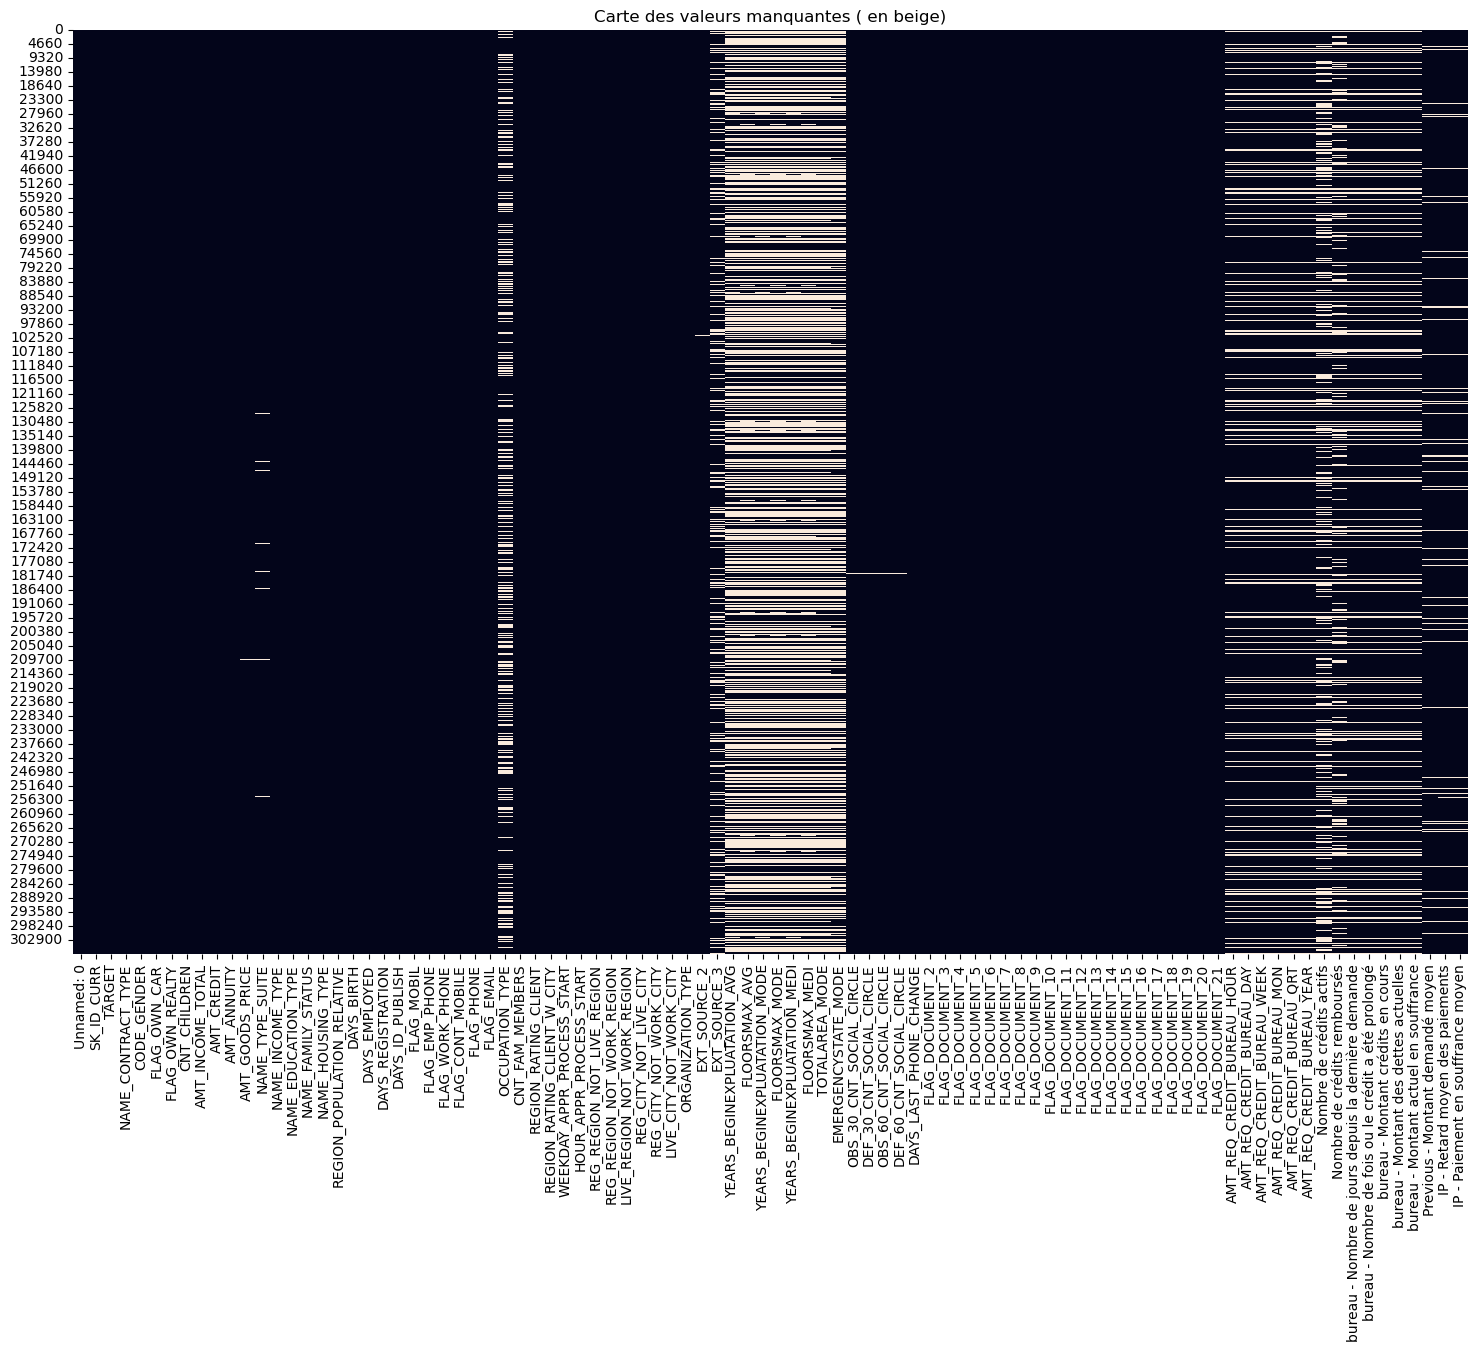

In [4]:
plt.figure(figsize=(18,12))
heat_map = sns.heatmap(df2.isnull(),cbar = False)
plt.title("Carte des valeurs manquantes ( en beige)")
plt.show()

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 92 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Unnamed: 0                                           307511 non-null  int64  
 1   SK_ID_CURR                                           307511 non-null  int64  
 2   TARGET                                               307511 non-null  int64  
 3   NAME_CONTRACT_TYPE                                   307511 non-null  object 
 4   CODE_GENDER                                          307511 non-null  object 
 5   FLAG_OWN_CAR                                         307511 non-null  object 
 6   FLAG_OWN_REALTY                                      307511 non-null  object 
 7   CNT_CHILDREN                                         307511 non-null  int64  
 8   AMT_INCOME_TOTAL                                     3

In [8]:
application_train = df2.copy()

In [9]:
application_train['EMERGENCYSTATE_MODE'] = application_train['EMERGENCYSTATE_MODE'].replace(['No'], 0)
application_train['EMERGENCYSTATE_MODE'] = application_train['EMERGENCYSTATE_MODE'].replace(['Yes'], 1)
application_train['FLAG_OWN_REALTY'] = application_train['FLAG_OWN_REALTY'].replace(['N'], 0)
application_train['FLAG_OWN_REALTY'] = application_train['FLAG_OWN_REALTY'].replace(['Y'], 1)
application_train['FLAG_OWN_CAR'] = application_train['FLAG_OWN_CAR'].replace(['N'], 0)
application_train['FLAG_OWN_CAR'] = application_train['FLAG_OWN_CAR'].replace(['Y'], 1)
application_train['CODE_GENDER'] = application_train['CODE_GENDER'].replace(['M'], 0)
application_train['CODE_GENDER'] = application_train['CODE_GENDER'].replace(['F'], 1)
application_train['CODE_GENDER'] = application_train['CODE_GENDER'].apply(lambda x: x if x in [0, 1] else np.nan)

In [10]:
# Encodage en One Hot
one_hot_encoded_data = pd.get_dummies(application_train, columns = ['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                                                                   'OCCUPATION_TYPE','NAME_HOUSING_TYPE',
                                                                   'NAME_FAMILY_STATUS','NAME_INCOME_TYPE',
                                                                   'NAME_TYPE_SUITE','NAME_CONTRACT_TYPE',
                                                                   'NAME_EDUCATION_TYPE',])
one_hot_encoded_data.drop(columns=['Unnamed: 0'], inplace=True)
one_hot_encoded_data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
0,100002,1,0.0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,1,1,0,0,0,0,0,1
1,100003,0,1.0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,1,0,0,1,0,0,0
2,100004,0,0.0,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,1,0,1,0,0,0,0,1
3,100006,0,1.0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,1,1,0,0,0,0,0,1
4,100007,0,0.0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,1,1,0,0,0,0,0,1


In [11]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 199 entries, SK_ID_CURR to NAME_EDUCATION_TYPE_Secondary / secondary special
dtypes: float64(39), int64(43), uint8(117)
memory usage: 226.7 MB


In [12]:
threshold = 0.1  # 10% threshold

# calcul du nombre de valeurs manquantes par colonne
missing_values = one_hot_encoded_data.isnull().sum()

# calcul du pourcentage de valeurs manquantes par colonne
percent_missing = missing_values / len(one_hot_encoded_data)

# sélection des colonnes avec au moins 10% de valeurs manquantes
selected_columns = percent_missing[percent_missing >= threshold].index

# sous-ensemble de données avec uniquement les colonnes sélectionnées
new_df = one_hot_encoded_data[selected_columns]

<Axes: >

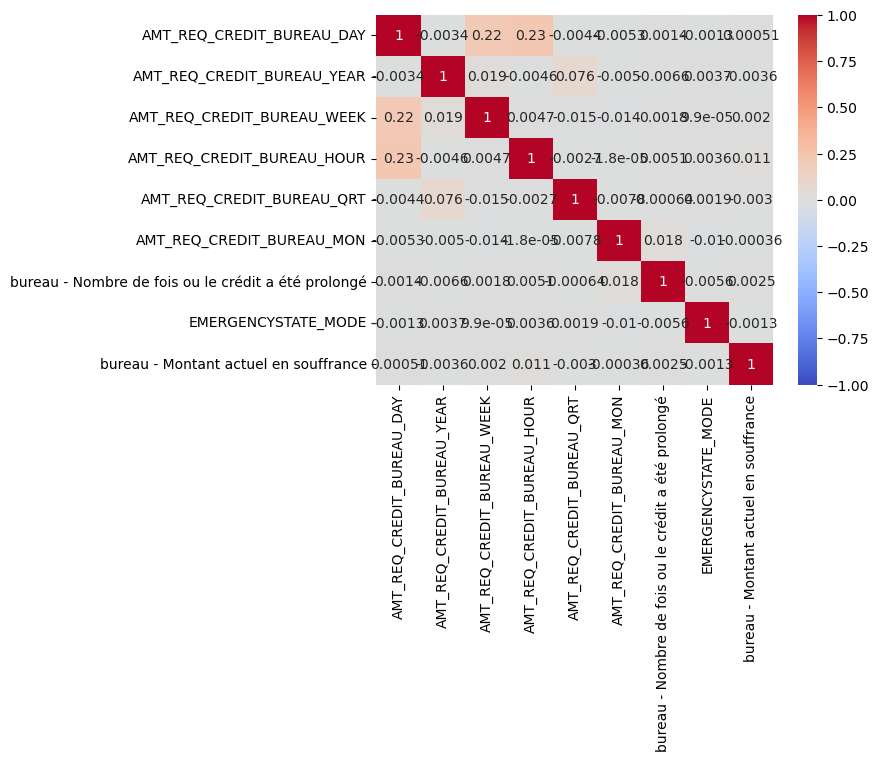

In [11]:
corr_matrix = new_df.corr().abs()
high_corr_var = np.where(corr_matrix > 0.25)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
low_corr_var = list(set(new_df.columns) - set(pd.DataFrame(high_corr_var).unstack().unique()))
df_low_corr = new_df[low_corr_var]
corr = df_low_corr.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

In [18]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['bureau - Montant actuel en souffrance'].sort_values(ascending=False)
print(target_correlations)

bureau - Montant actuel en souffrance    1.000000
FLAG_WORK_PHONE                          0.013355
TARGET                                   0.013335
Nombre de crédits actifs                 0.012455
OCCUPATION_TYPE_HR staff                 0.012124
                                           ...   
YEARS_BEGINEXPLUATATION_MEDI            -0.006931
YEARS_BEGINEXPLUATATION_AVG             -0.007017
EXT_SOURCE_3                            -0.025386
FLAG_MOBIL                                    NaN
FLAG_DOCUMENT_2                               NaN
Name: bureau - Montant actuel en souffrance, Length: 199, dtype: float64


In [19]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['EMERGENCYSTATE_MODE'].sort_values(ascending=False)
print(target_correlations)

EMERGENCYSTATE_MODE                                  1.000000
REGION_RATING_CLIENT                                 0.038231
REGION_RATING_CLIENT_W_CITY                          0.034410
NAME_EDUCATION_TYPE_Secondary / secondary special    0.032352
NAME_HOUSING_TYPE_Municipal apartment                0.029482
                                                       ...   
REGION_POPULATION_RELATIVE                          -0.046912
TOTALAREA_MODE                                      -0.098673
FLOORSMAX_MEDI                                      -0.136327
FLOORSMAX_AVG                                       -0.136604
FLOORSMAX_MODE                                      -0.138289
Name: EMERGENCYSTATE_MODE, Length: 199, dtype: float64


In [20]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['bureau - Nombre de fois ou le crédit a été prolongé'].sort_values(ascending=False)
print(target_correlations)

bureau - Nombre de fois ou le crédit a été prolongé    1.000000
Nombre de crédits actifs                               0.102248
Nombre de crédits remboursés                           0.082001
ORGANIZATION_TYPE_Transport: type 2                    0.074904
bureau - Montant crédits en cours                      0.056238
                                                         ...   
NAME_INCOME_TYPE_Pensioner                            -0.036898
DAYS_EMPLOYED                                         -0.037271
bureau - Nombre de jours depuis la dernière demande   -0.073208
FLAG_MOBIL                                                  NaN
FLAG_DOCUMENT_2                                             NaN
Name: bureau - Nombre de fois ou le crédit a été prolongé, Length: 199, dtype: float64


In [21]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_MON'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_MON                              1.000000
Nombre de crédits remboursés                           0.136710
REGION_POPULATION_RELATIVE                             0.078607
Nombre de crédits actifs                               0.078495
bureau - Montant crédits en cours                      0.067481
                                                         ...   
REGION_RATING_CLIENT_W_CITY                           -0.067741
REGION_RATING_CLIENT                                  -0.069712
bureau - Nombre de jours depuis la dernière demande   -0.123346
FLAG_MOBIL                                                  NaN
FLAG_DOCUMENT_2                                             NaN
Name: AMT_REQ_CREDIT_BUREAU_MON, Length: 199, dtype: float64


In [22]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_QRT'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_QRT            1.000000
AMT_REQ_CREDIT_BUREAU_YEAR           0.076208
NAME_CONTRACT_TYPE_Cash loans        0.021962
AMT_GOODS_PRICE                      0.016432
AMT_CREDIT                           0.015925
                                       ...   
FLAG_WORK_PHONE                     -0.022964
EXT_SOURCE_3                        -0.025131
IP - Paiement en souffrance moyen   -0.026072
FLAG_MOBIL                                NaN
FLAG_DOCUMENT_2                           NaN
Name: AMT_REQ_CREDIT_BUREAU_QRT, Length: 199, dtype: float64


In [23]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_HOUR'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_HOUR              1.000000
AMT_REQ_CREDIT_BUREAU_DAY               0.230374
WEEKDAY_APPR_PROCESS_START_SUNDAY       0.018005
FLAG_DOCUMENT_12                        0.016142
bureau - Montant crédits en cours       0.015300
                                          ...   
NAME_HOUSING_TYPE_House / apartment    -0.006745
WEEKDAY_APPR_PROCESS_START_WEDNESDAY   -0.010697
HOUR_APPR_PROCESS_START                -0.016005
FLAG_MOBIL                                   NaN
FLAG_DOCUMENT_2                              NaN
Name: AMT_REQ_CREDIT_BUREAU_HOUR, Length: 199, dtype: float64


In [24]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_WEEK'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_WEEK            1.000000
AMT_REQ_CREDIT_BUREAU_DAY             0.217412
FLAG_EMAIL                            0.021581
AMT_REQ_CREDIT_BUREAU_YEAR            0.018917
NAME_CONTRACT_TYPE_Cash loans         0.015296
                                        ...   
AMT_REQ_CREDIT_BUREAU_QRT            -0.015115
NAME_CONTRACT_TYPE_Revolving loans   -0.015296
EXT_SOURCE_3                         -0.021258
FLAG_MOBIL                                 NaN
FLAG_DOCUMENT_2                            NaN
Name: AMT_REQ_CREDIT_BUREAU_WEEK, Length: 199, dtype: float64


In [25]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_YEAR'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_YEAR                           1.000000
Previous - Montant demandé moyen                     0.168599
AMT_REQ_CREDIT_BUREAU_QRT                            0.076208
FLAG_OWN_REALTY                                      0.067451
NAME_EDUCATION_TYPE_Secondary / secondary special    0.065976
                                                       ...   
FLAG_WORK_PHONE                                     -0.075875
IP - Paiement en souffrance moyen                   -0.082937
DAYS_LAST_PHONE_CHANGE                              -0.112725
FLAG_MOBIL                                                NaN
FLAG_DOCUMENT_2                                           NaN
Name: AMT_REQ_CREDIT_BUREAU_YEAR, Length: 199, dtype: float64


In [26]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_DAY'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_DAY            1.000000
AMT_REQ_CREDIT_BUREAU_HOUR           0.230374
AMT_REQ_CREDIT_BUREAU_WEEK           0.217412
FLAG_DOCUMENT_18                     0.013281
FLAG_DOCUMENT_14                     0.013119
                                       ...   
EXT_SOURCE_3                        -0.007190
FLAG_OWN_REALTY                     -0.009267
WEEKDAY_APPR_PROCESS_START_MONDAY   -0.010947
FLAG_MOBIL                                NaN
FLAG_DOCUMENT_2                           NaN
Name: AMT_REQ_CREDIT_BUREAU_DAY, Length: 199, dtype: float64


Nous supprimons ces variables pour utiliser IterativeImputer

In [27]:
one_hot_encoded_data.drop(columns=['AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_WEEK',
                                  'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_QRT',
                                  'AMT_REQ_CREDIT_BUREAU_MON','bureau - Nombre de fois ou le crédit a été prolongé',
                                  'EMERGENCYSTATE_MODE','bureau - Montant actuel en souffrance'], inplace=True)

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp=IterativeImputer()
imputed = imp.fit_transform(one_hot_encoded_data)
df_imputed = pd.DataFrame(imputed, columns = one_hot_encoded_data.columns)

C:\Users\Jérôme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
(df_imputed.isna().sum()/df_imputed.shape[0])*100

SK_ID_CURR                                           0.0
TARGET                                               0.0
CODE_GENDER                                          0.0
FLAG_OWN_CAR                                         0.0
FLAG_OWN_REALTY                                      0.0
                                                    ... 
NAME_EDUCATION_TYPE_Academic degree                  0.0
NAME_EDUCATION_TYPE_Higher education                 0.0
NAME_EDUCATION_TYPE_Incomplete higher                0.0
NAME_EDUCATION_TYPE_Lower secondary                  0.0
NAME_EDUCATION_TYPE_Secondary / secondary special    0.0
Length: 199, dtype: float64

In [15]:
df_impute d.shape

(307511, 199)

In [16]:
df_imputed.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
0,100002.0,1.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003.0,0.0,1.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,100004.0,0.0,0.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,100006.0,0.0,1.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007.0,0.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
df_imputed.drop(columns=['SK_ID_CURR'], inplace=True)

In [ ]:
df_imputed.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df2.csv')

# Possibilité de Data Leakage

In [28]:
# Import des données
df =pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df2.csv')

In [3]:
# Calculer les corrélations
correlations = df.corr()
# Corrélations avec la variable cible
target_correlations = correlations['TARGET'].sort_values(ascending=False)
print(target_correlations)

TARGET                                                 1.000000
bureau - Nombre de jours depuis la dernière demande    0.083263
DAYS_BIRTH                                             0.078239
Nombre de crédits actifs                               0.074147
REGION_RATING_CLIENT_W_CITY                            0.060893
                                                         ...   
NAME_INCOME_TYPE_Pensioner                            -0.046209
CODE_GENDER                                           -0.054710
NAME_EDUCATION_TYPE_Higher education                  -0.056593
EXT_SOURCE_2                                          -0.160601
EXT_SOURCE_3                                          -0.198802
Name: TARGET, Length: 200, dtype: float64


In [4]:
# Il n'y a aucun problème de Data Leakage